# Homework 4

In this homework you will continue to work with the subsection of the ethanol spectrum loaded below:

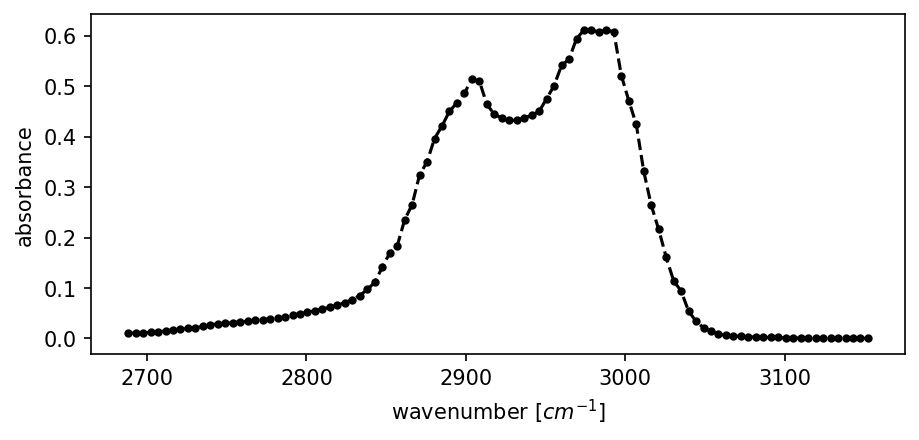

In [1]:
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_csv('ethanol_IR.csv')
x_peak = df['wavenumber [cm^-1]'].values[475:575].reshape(-1)
y_peak = df['absorbance'].values[475:575]

fig, ax = plt.subplots(figsize = (7, 3), dpi = 150)
ax.plot(x_peak, y_peak, '--k', marker = '.')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

## 1. LASSO Regularization and Hyperparameter Tuning

You will make use of a LASSO regression and tune its hyperparameters. You will optimize `alpha` and `gamma` as you did in the Skill Check. However, there is no "KernelLASSO" model implemented in `scikit-learn`, so you will need to construct the kernel manually, then use the kernel matrix as input to the `scikit-learn` LASSO implementation. Note that since `gamma` is a hyperparameter of the RBF kernel, you will need to optimize it outside of the regression model.

Below are the requirements of this problem.

- Consider **at least 5** candidates for each `alpha` and `gamma`. You may select these candidates however you see fit, and may use trial and error to identify the best candidates.
- Use hold-out cross-validation with 30% of the dataset as the test set.

***Hint***
- Using `GridSearchCV` may make the problem even harder. Manually optimizing with `for` loops is an acceptable strategy.
- This [document](https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html) provides a way to customize the line style.
- You may create your own `rbf` function or use `sklearn.metrics.pairwise.rbf_kernel`. Please read the [official document](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html) of the `rbf_kernel` function **carefully** when you try to use it.
- Be mindful of **data leakage** to the test set. Applying an RBF kernel to the dataset before splitting it possesses a risk of data leakge, which is regarded as a from of "cheating" in machine learning. The test set must be kept totally separate from the training set so that the model does not know anything about the test set.

### 1a. Model Optimization
Find the optimum model using hyperparameter optimization. It should be possible to find a model that has an $\mathrm{r^2}$ of at least 0.8 on the test set.

Report the optimum `alpha` and `gamma`, along with the optimium $r^2$ and MAE values.


In [2]:
import warnings

# ignore warning messages
warnings.simplefilter('ignore')

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_absolute_error

In [4]:
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
sigmas = np.array([10, 20, 30, 40, 50, 60])
gammas = 1 / 2 / sigmas**2

x_peak = x_peak.reshape(-1, 1)
y_peak = y_peak.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size = .3, random_state = 42)

In [5]:
r2 = np.zeros((len(alphas), len(gammas)))
MAE = np.zeros((len(alphas), len(gammas)))

for i, alpha in enumerate(alphas):
    for j, gamma in enumerate(gammas):
        X_train = rbf_kernel(x_train, x_train, gamma = gamma)
        X_test = rbf_kernel(x_test, x_train, gamma = gamma)
        
        lasso = Lasso(alpha = alpha)
        
        lasso.fit(X_train, y_train)
        r2[i, j] = lasso.score(X_test, y_test)
        MAE[i, j] = mean_absolute_error(y_test, lasso.predict(X_test))

In [6]:
print('maximum r2: {}'.format(r2.max()))

max_index = np.argmax(r2.max())
opt_alpha_index = max_index // len(alphas)
opt_gamma_index = max_index % len(alphas)

print('optimum alpha: {}'.format(alphas[opt_alpha_index]))
print('optimum gamma: {}'.format(gammas[opt_gamma_index]))
print('optimum MAE: {}'.format(MAE[opt_alpha_index, opt_gamma_index]))

maximum r2: 0.9982747492490963
optimum alpha: 1e-06
optimum gamma: 0.005
optimum MAE: 0.0058886486535357765


### 1b. Model visualization
Visualization of a model is a great way to assess its validity.  Plot the following outputs from the optimum model on a single figure.

* predictions on the training set in blue solid dots
* predictions on the test set in red solid dots
* the original data in black solid line

In [7]:
X_train = rbf_kernel(x_train, x_train, gamma = gammas[opt_gamma_index])
X_test = rbf_kernel(x_test, x_train, gamma = gammas[opt_gamma_index])

lasso = Lasso(alpha = alphas[opt_alpha_index])

lasso.fit(X_train, y_train)
y_train_hat = lasso.predict(X_train)
y_test_hat = lasso.predict(X_test)

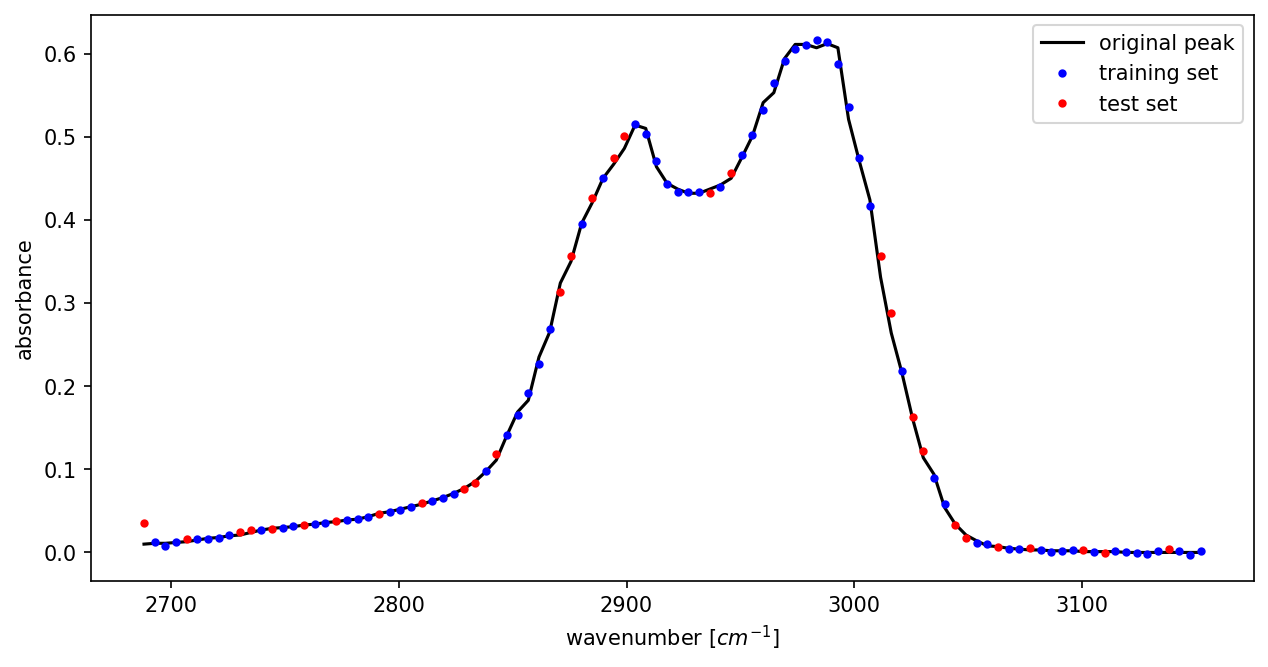

In [8]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)

ax.plot(x_peak, y_peak, '-k', label = 'original peak')
ax.plot(x_train, y_train_hat, '.b', label = 'training set')
ax.plot(x_test, y_test_hat, '.r', label = 'test set')

ax.legend()

ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

### 1c. Model interpretation

How many coefficients does the optimum model have? How would you interpret those coefficients in terms of the peaks of the spectrum?

Please briefly explain in 2-3 sentences.

In [9]:
coefs = lasso.coef_
dropped_coefs = coefs[coefs != 0]

print('the number of coefficients of the optimum model: {}'.format(len(dropped_coefs)))
print('the number of coefficients dropped: {}'.format(len(coefs) - len(dropped_coefs)))

the number of coefficients of the optimum model: 70
the number of coefficients dropped: 0


**The answer above may change depending on the selection of alphas and gammas. Just because the number of coefficients dropped is different, that doesn't mean your peer has the wrong answer.**

The beauty of utilizing a LASSO model is that unnecessary features can be excluded during the training procedure. Since we use the rbf features to fit the IR spectra, we can argue that the rbf feature at a certain wavenumber would be irrelevant to the peak information if the feature was dropped.

## 2. Shuffling and Cross Validation

In the Skill Check, shuffling preceded `GridSearchCV`. In this problem, you will see what happens when shuffling does not occur prior to k-fold cross validation (and why it is necessary for this dataset). 

* Use the `KFold` class to perform 5-fold cross validation directly on the spectrum data. By declaring `KFold(n_splits = 5, shuffle = False)`, the k-fold object splits the dataset into 5 consecutive folds. This means the first fold will use the first 20% of the data for testing, and the next 20% will be the testing data for the second fold, and so forth.

* For each of the 5 data splits, create an independently optimized `KernelRidge` model. For each split, you should train the model with 80% of the data and test it on 20%. Use `GridSearchCV` to optimize `gamma` and `alpha` separately for each split. You may select the ranges over which to optimize `gamma` and `alpha`. The result should be 5 separate `KernelRidge` models, each trained to a different 80% of the data, and each one with potentially different hyperparameters.

### 2a. Visualization and analysis of models


Report the $r^2$ value using the entire `x_peak` dataset with each model. Plot the prediction of each model with different colors on a single plot, and include the original data as a black line.

In [10]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.kernel_ridge import KernelRidge

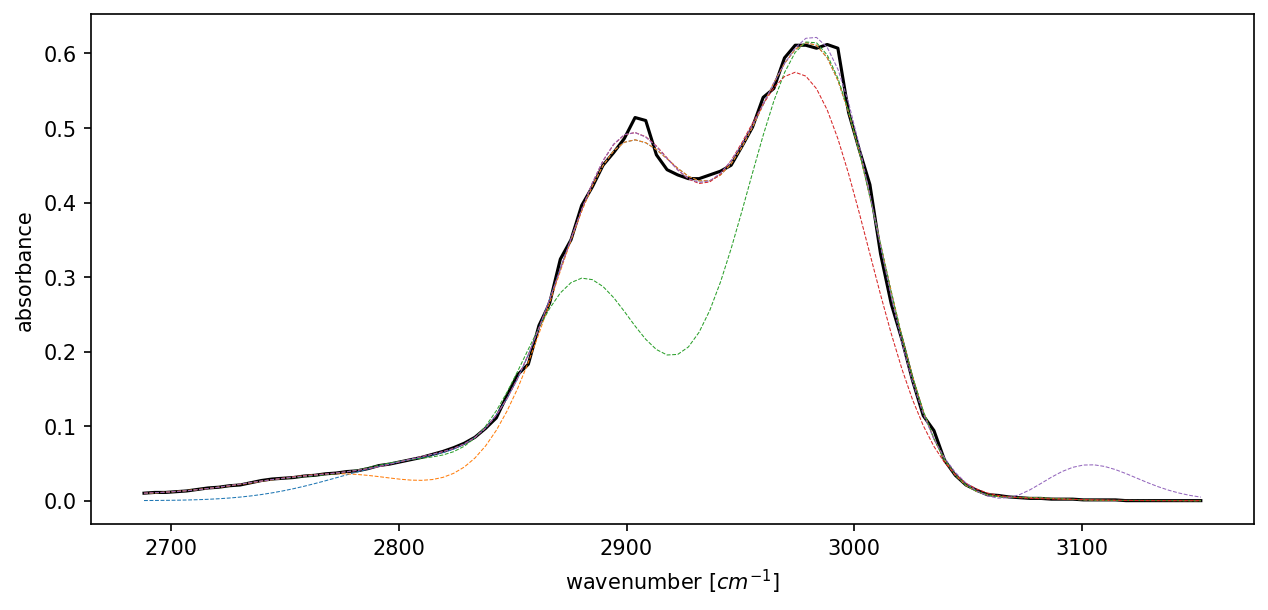

In [11]:
kf = KFold(n_splits = 5, shuffle = False)

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
sigmas = np.array([10, 20, 30, 40, 50, 60])
gammas = 1 / 2 / sigmas**2

param_grid = {'alpha': alphas, 'gamma': gammas}

fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)
ax.plot(x_peak, y_peak, '-k', label = 'original peak')

predictions = []

for train_index, test_index in kf.split(x_peak):
    x_train, x_test = x_peak[train_index], x_peak[test_index]
    y_train, y_test = y_peak[train_index], y_peak[test_index]
    
    krr = KernelRidge(kernel = 'rbf')
    krr_search = GridSearchCV(krr, param_grid, cv = 5)
    krr_search.fit(x_train, y_train)
    
    ax.plot(x_peak, krr_search.best_estimator_.predict(x_peak), '--', lw = 0.5)
    
    predictions.append(krr_search.best_estimator_.predict(x_peak))
    
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance');

### 2b. Variance between models

Plot the standard deviation of the 5 model predictions as a function of wavenumber (i.e. the x-axis is wavenumber and the y-axis is the standard deviation of the 5 different predictions from each model).

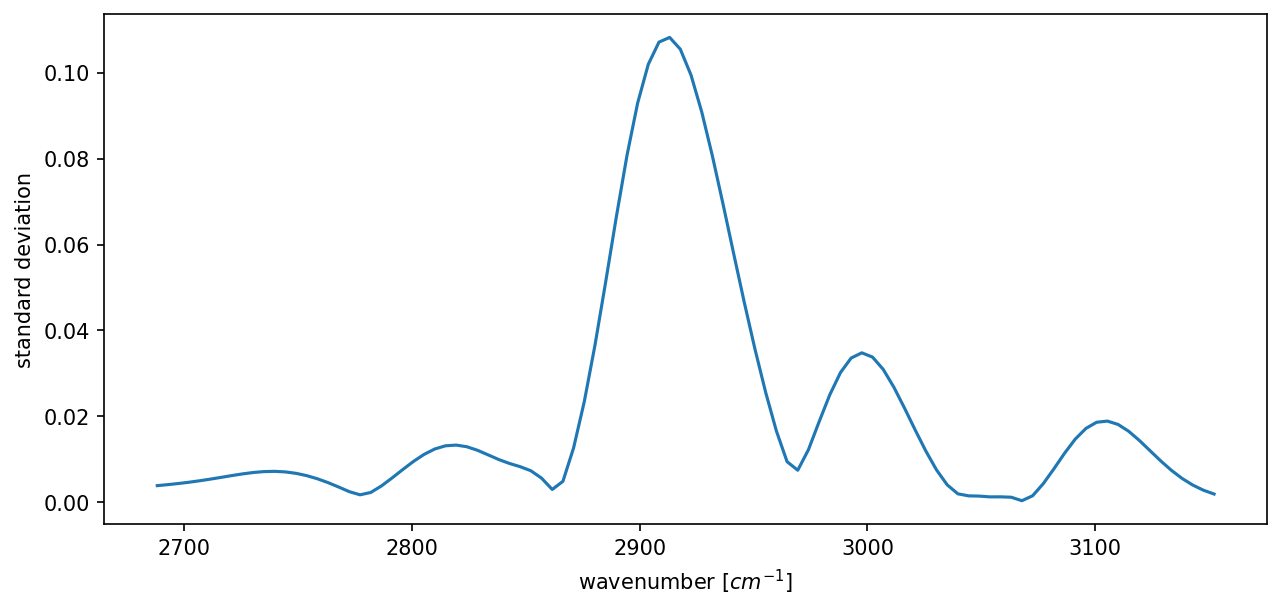

In [12]:
fig, ax = plt.subplots(figsize = (10, 4.5), dpi = 150)

ax.plot(x_peak, np.std(predictions, axis = 0))
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('standard deviation');

### 2c. Homoscedasticity

Is the prediction error from the different models homoscedastic? Briefly explain why.

It is heteroscedastic. The standard deviation is obviously dependent of wavenumbers.

### 2d. Model evaluation

Which model is most reliable? Why is it necessary to "shuffle" the data during k-fold cross-validation in this case?

I would choose the blue one (the first model) where the first 20% of the data was used as a hold-out set. The orange one (the seconde model) and the purple one (the fifth model) are also reliable. This is basically because those models had very good training sets. We all know that the most important information is located in a range from 2850 $\mathrm{cm^{-1}}$ to 3050 $\mathrm{cm^{-1}}$ and these 3 models had the training sets that contain all the data within this range. We can say these models are **lucky** while others are unlucky. To prevent models from having this kind of lucky cases, we should shuffle the data in the beginning so that all models during the cross-validation step would have training sets of which data points are well distributed across the whole range.